# **1. Download and preparing the dataset**
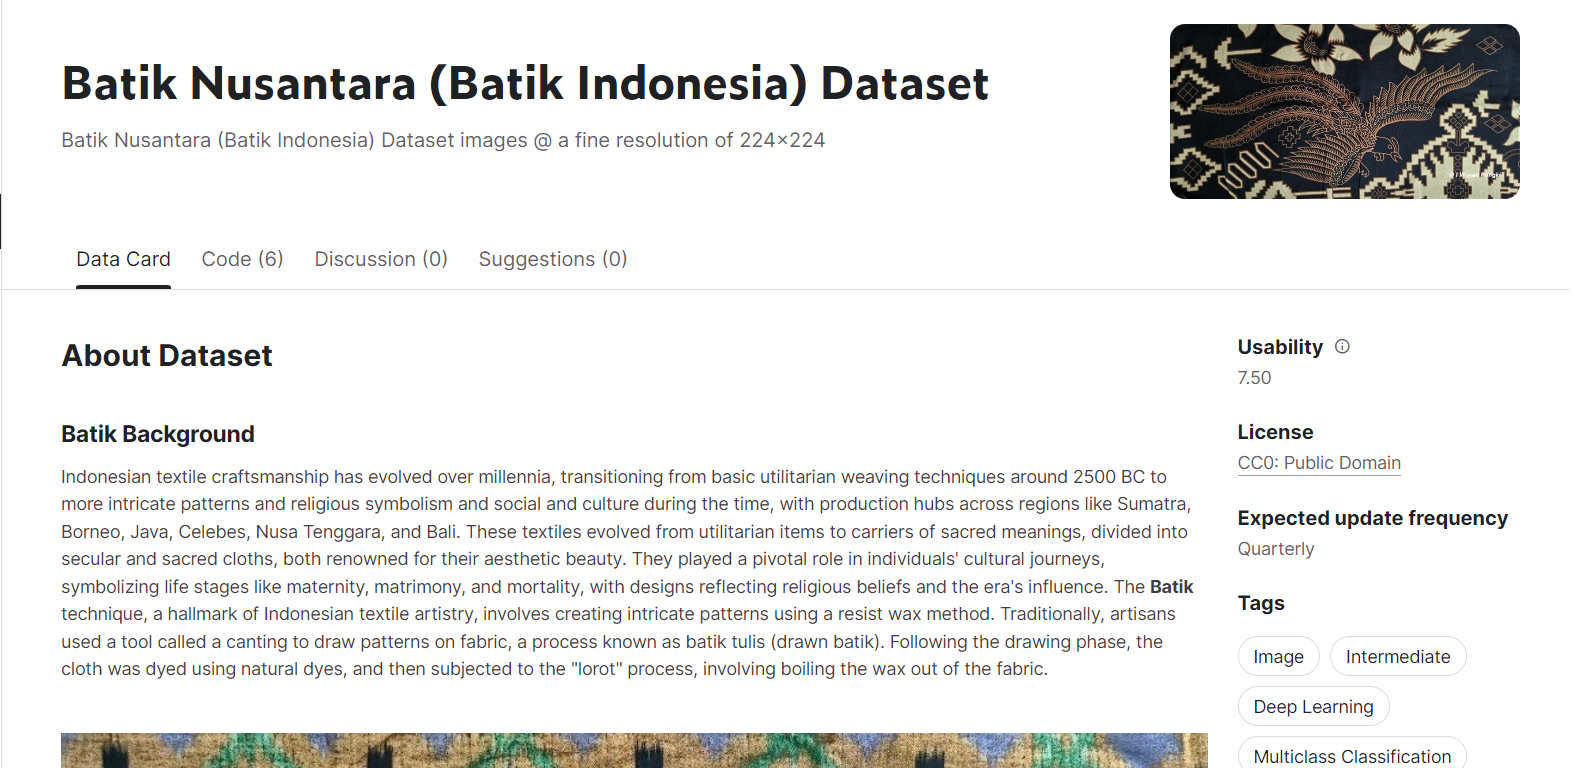
Link to our datasets :

https://www.kaggle.com/datasets/hendryhb/batik-nusantara-batik-indonesia-dataset

We download it using this link : https://drive.google.com/file/d/1tWiO8DN1IHmImCWz2EVgERROpYSIC5Ot/view?usp=sharing

In [ ]:
# Run this code to download the dataset
!gdown 1tWiO8DN1IHmImCWz2EVgERROpYSIC5Ot

Then we will extract it to the current directory

In [ ]:
# Run this code to extract the file
import zipfile

dataset_zip = './raw_batik_v2.1.zip'
zip_read = zipfile.ZipFile(dataset_zip, 'r')
zip_read.extractall()
zip_read.close()

 Checking the contents of the folder

In [ ]:
import os

base_dir = './raw_batik_v2.1'

print("Content of base directory:")
print(os.listdir(base_dir))

print("\nContent of train directory:")
print(os.listdir(f'{base_dir}/train'))

print("\nContent of test directory:")
print(os.listdir(f'{base_dir}/test'))

Create variable for shortcut of **train and test path**

In [ ]:
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')

Checking total images in every sub-directory of **train**

In [ ]:
for folder in os.listdir(train_dir):
    sub_dir = os.path.join(train_dir, folder)
    if os.path.isdir(sub_dir):  # Check if it's a directory
        # List only image files in the subdirectory
        image_files = [f for f in os.listdir(sub_dir) if os.path.isfile(os.path.join(sub_dir, f)) and f.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp', '.tiff'))]
        print(f'{folder} : {len(image_files)} images')

Checking total images in every sub-directory of **test**

In [ ]:
for folder in os.listdir(test_dir):
    sub_dir = os.path.join(test_dir, folder)
    if os.path.isdir(sub_dir):  # Check if it's a directory
        # List only image files in the subdirectory
        image_files = [f for f in os.listdir(sub_dir) if os.path.isfile(os.path.join(sub_dir, f)) and f.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp', '.tiff'))]
        print(f'{folder} : {len(image_files)} images')

# **2. Building the Model**


## **2.1 Preparation**

Import Libraries that will be needed for this project :
    - tensorflow
    - numpy
    - matplotplib
    - tensorflows js

In [ ]:
# Tensorflow
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Additional Library
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

Preprocessing the image using ImageDataGenerator.We also use augmentation technique to avoid overfitting.

In [ ]:
train_datagen = ImageDataGenerator(
                    rescale=1.0/255.0,
                    rotation_range=20,
                    width_shift_range=0.2,
                    height_shift_range=0.2,
                    zoom_range=0.6,
                    horizontal_flip=True,
                    shear_range = 0.2,
                    fill_mode = 'nearest')

test_datagen = ImageDataGenerator(rescale=1.0/255.0,)

# Flow training images in batches of 32 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(224, 224),
        batch_size=32,
        class_mode='sparse', #we use this because we are classifying multiples object
        shuffle=True) # shuffle the train to avoid overfitting

validation_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(224, 224),
        batch_size=32,
        class_mode='sparse')

## **2.2 Creating the model architecture**

We use the pre-trained model to boost our accuracy, but we only use a couple of layers of the pre-trained model and add our own layers

### **2.2.1 Transfer learning Preparation**

The pre-trained model that we use is VGG16. The reason why we chose VGG16 is simply because its architecture is not as complex as another pre-trained model. The model size is also small compared to the other.

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model

In [ ]:
# Load model VGG16 sebagai base model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [ ]:
# We set the layers to untrainable
for layer in base_model.layers:
    layer.trainable = False

base_model.summary()

### **2.2.2 Creating the model**

We reduced a couples of layers.
After trying multiple different architectures,
we found out that if we reduced up to 6 last layers. We get the highest possible accuracy (currently).

In [ ]:
# Reducing the last 6 layers

reduced_pre_trained_model = Model(base_model.input, base_model.layers[-6].output)
reduced_pre_trained_model.summary()

In [ ]:
# We added our own layers
# We simply use Conv2 layer with 3x3 kernel size and
# MaxPool2D with pool_size of 2x2

x = reduced_pre_trained_model.output
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Conv2D(512, (3,3), activation='relu')(x)
x = tf.keras.layers.Conv2D(512, (3,3), activation='relu')(x)
x = tf.keras.layers.MaxPool2D(2,2)(x)
x = tf.keras.layers.Conv2D(1024, (3,3), activation='relu')(x)
x = tf.keras.layers.Conv2D(1024, (3,3), activation='relu')(x)
x = tf.keras.layers.MaxPool2D(2,2)(x)

x = tf.keras.layers.Flatten()(x) # Flatten the output of previous layers (Convolutional)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)  # Use dropout layer to avoid overfitting
# Since our entire class consists of 20, the final layer unit is 20.
# We use the softmax activation function to output the label based on the highest probability
predictions = tf.keras.layers.Dense(20, activation='softmax')(x)

In [ ]:
# Create the model
model = Model(inputs=reduced_pre_trained_model.input, outputs=predictions)
model.summary()

In [ ]:
from tensorflow.keras.utils import plot_model

plot_model(model, to_file='model.png', show_shapes=True)

### **2.2.3 Train the model**

In [ ]:
# Try using multiple optimizers
# We found out that Adam is the best for our model
opt = tf.keras.optimizers.RMSprop(learning_rate=0.0001)
opt2 = tf.keras.optimizers.Adam(learning_rate=0.0001)
opt3 = tf.keras.optimizers.SGD(learning_rate=0.0001)

model.compile(loss='sparse_categorical_crossentropy',
              optimizer=opt2,
              metrics=['accuracy'])

In [ ]:
history = model.fit(
      train_generator,
      steps_per_epoch=10,
      epochs=125,
      validation_data=validation_generator,
      validation_steps=5,
      verbose=2,)

## **2.3 Plot the accuracy of training and validation**

In [ ]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# **3. Converting our model to TensorFlow JS**

In [ ]:
# This is if we running on google colab or if we do not have keras-preprocessing module
!pip install keras-preprocessing
!!pip install tensorflowjs

In [ ]:
# Save the model
model.save('model_v3.h5')

# Convert our model to tensorflow js
!tensorflowjs_converter --input_format=keras model_v3.h5 tfjs_model

# Zip the tfjs folder
!zip -r tfjs_model.zip tfjs_model

# **4. Testing our model**

Manually test our model with uploading the batik images that we want to classify

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import os
from google.colab import files

!gdown 1wRX4pTJpPVadTGBcgwwepWei2MGi60lq

# Load the trained model
model = tf.keras.models.load_model('model_v3.h5')

# Directory where your test images are located
# test_images_dir = os.path.join('./raw_batik_v2.1', 'test')

# Get a list of all the subdirectories (classes)
# classes = os.listdir(test_images_dir)

classes = ['Batik Aceh Pintu Aceh', 'Batik Kalimantan Dayak', 'Batik Maluku Pala', 'Batik Papua Asmat', 'Batik NTB Lumbung', 'Batik Solo Parang', 'Batik DKI Ondel-ondel', 'Batik Sumatera Utara Boraspati', 'Batik Papua Cendrawasih', 'Batik Jawa Timur Pring', 'Batik Sulawesi Selatan Lontara', 'Batik Bali Merak', 'Batik Madura Mataketeran', 'Batik Papua Tifa', 'Batik Yogyakarta Kawung', 'Batik Yogyakarta Parang', 'Batik Jawa Barat Megamendung', 'Batik Sumatera Barat Rumah Minang', 'Batik Lampung Gajah', 'Batik Bali Barong']

# Function to preprocess the image for prediction
def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))  # Resize the image to the target size
    img_array = image.img_to_array(img)  # Convert the image to a numpy array
    img_array = np.expand_dims(img_array, axis=0)  # Expand dimensions to match the input shape of the model
    img_array /= 255.0  # Normalize the image
    return img_array

# Function to make predictions
def predict_image(img_path):
    img_array = preprocess_image(img_path)
    predictions = model.predict(img_array)
    return predictions

In [ ]:
uploaded = files.upload()

for fn in uploaded.keys():
    # predicting images
    path = fn
    predictions = predict_image(path)
    predicted_class = np.argmax(predictions, axis=1)[0]  # Get the class with the highest probability
    predicted_class_name = classes[predicted_class]  # Map index to class name

    # Print the predicted class
    confidence = np.max(predictions)
    print(f'Image: {path}, Predicted class: {predicted_class_name}')
    print(f"Confidence: {confidence * 100:.2f}%")

    # Optionally, plot the image and the predicted class
    img = image.load_img(path, target_size=(224, 224))
    plt.imshow(img)
    plt.title(f'Predicted class: {predicted_class_name}')
    plt.axis('off')
    plt.show()

# **5. Clean UP**

clean up for google colab's env

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import os, signal

!rm -rf 'raw_batik_v2.1'
!rm -rf 'raw_batik_v2.1.zip'
os.kill(os.getpid(), signal.SIGKILL)